In [1]:
from data_common.notebook import *
from data_common.pandas.df_extensions.space import SpacePDAccessor as SpaceCluster
from la_emissions_data.la_mapping import (
    lower_tier_sandwich,
    lower_tier_layer,
    gdf_chart,
)

In [2]:
df = (
    pd.read_csv(Path("data", "interim", "la_emissions_similarity.csv"))
    .la.get_council_info(["local-authority-type-name"])
    .set_index("local-authority-code")
    .drop(["LND"])
)

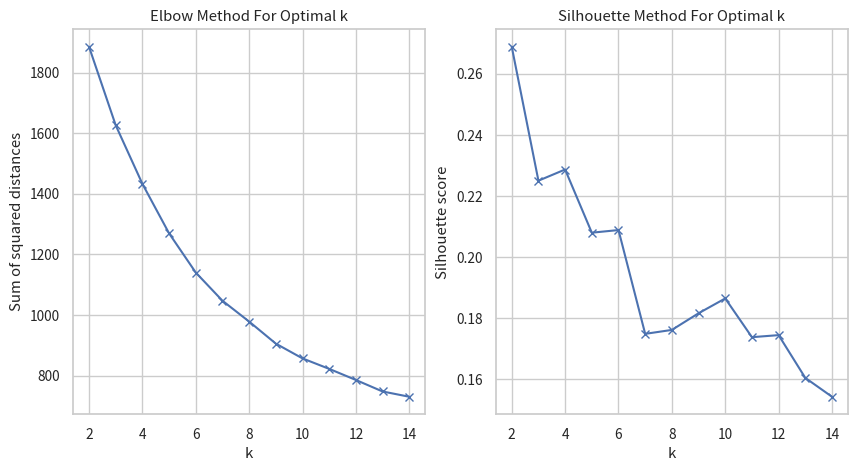

In [3]:
def density_transform(series):
    return series * 0.25


c = SpaceCluster(df).cluster(
    normalize=True,
    label_cols=["local-authority-type-name"],
    transform={"pop_density": density_transform},
)  # lets make density a bit less important after normalization
c.find_k()

In [4]:
t = c.set_k(6).label_tool()

interactive(children=(Dropdown(description='cluster', options=(1, 2, 3, 4, 5, 6), value=1), Dropdown(descripti…

In [5]:
c.set_k(5).label_review(1)

cluster_count  \
variable                  value                                       
Total                     Total                                  42   
agriculture_by_gdp        High                                   42   
commerical_by_gdp         High                                   16   
                          Low                                    18   
                          Medium                                  8   
domestic_by_pop           High                                   34   
                          Low                                     2   
                          Medium                                  6   
industry_by_gdp           High                                   28   
                          Low                                     2   
                          Medium                                 12   
local-authority-type-name County                                  1   
                          NI district                             6   
                          Non-metropolitan district              15   
                          Scottish unitary authority             10   
                          Unitary authority                       3   
                          Welsh unitary authority                 7   
pop_density               High                                    1   
                          Low                                    40   
                          Medium                                  1   
public_sector_by_wpop     High                                    5   
                          Low                                    28   
                          Medium                                  9   
transport_by_wpop         High                                   29   
                          Low                                     5   
                          Medium                                  8   

                                                      overall_count  \
variable                  value                                       
Total                     Total                                 408   
agriculture_by_gdp        High                                  136   
commerical_by_gdp         High                                  136   
                          Low                                   136   
                          Medium                                136   
domestic_by_pop           High                                  136   
                          Low                                   136   
                          Medium                                136   
industry_by_gdp           High                                  136   
                          Low                                   136   
                          Medium                                136   
local-authority-type-name County                                 24   
                          NI district                            11   
                          Non-metropolitan district             181   
                          Scottish unitary authority             32   
                          Unitary authority                      59   
                          Welsh unitary authority                22   
pop_density               High                                  136   
                          Low                                   136   
                          Medium                                136   
public_sector_by_wpop     High                                  136   
                          Low                                   136   
                          Medium                                136   
transport_by_wpop         High                                  136   
                          Low                                   136   
                          Medium                                136   

                                                      % of cluster  % of lab

In [6]:
c.set_k(5).stats()

,count,%,random members
labels,,,
1,42,10.3,"[TOR, EDN, MRY, CCG, POW]"
2,161,39.5,"[WLA, LEC, WLI, EHE, CWY]"
3,168,41.2,"[BAI, ROC, WOT, SGC, IOS]"
4,26,6.4,"[ABE, TWH, WSM, CMD, PRE]"
5,11,2.7,"[ABC, NAY, SEL, RCC, ANN]"


In [7]:
c.set_k(5).raincloud_tool(reverse=True)

interactive(children=(Dropdown(description='cluster_label', options=(1, 2, 3, 4, 5), value=1), Output()), _dom…

In [8]:
cluster = c.set_k(5).set_anchor(Path("data", "interim", "cluster_anchor.csv"))

# cluster.store_anchor(Path("data", "interim", "cluster_anchor.csv"))

labels_d = {
    1: ("Agriculture", "Above average agriculture, domestic score"),
    2: (
        "Transport/Domestic",
        "Above average transport/domestic score",
    ),
    3: (
        "Urban Mainstream",
        "Below average for all emissions scores",
    ),
    4: (
        "Public sector",
        "Well above average public sector (government, education, health), below average in other areas.",
    ),
    5: (
        "Industry/Commerical/Domestic",
        "Above average for industry/domestic/doemestic, below average public sector emissions.",
    ),
}

labels_short_d = {x: y[0] for x, y in labels_d.items()}

cluster = cluster.add_labels(labels_d)

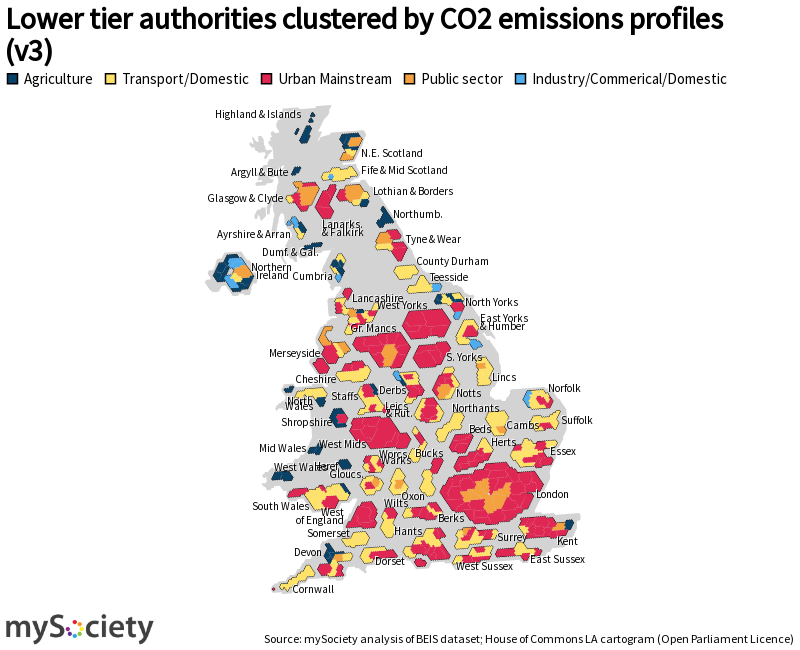

In [9]:
df["cluster_label"] = cluster.label_array(include_short=False)
df["cluster_label"] = df[
    "cluster_label"
]  # .common.update_from_map({"Industry/domestic/transport":"Ind./domestic/transport"})
la_layer = lower_tier_layer().join(df)

# labels = list(df["label"].unique())
# labels.sort(key=lambda x: x if x != "Other" else "Z", reverse=True)
labels = range(1, 6)

labels = [labels_short_d[x] for x in labels]

colors = [
    "colour_dark_blue",
    "colour_yellow",
    "colour_berry",
    "colour_orange",
    "colour_blue",
]

color_scale = altair_theme.color_scale(domain=labels, named_palette=colors)

# create chart layer
chart = (
    gdf_chart(la_layer)  # type: ignore
    .mark_geoshape(  # type:ignore
        stroke="black",  # type:ignore
        strokeWidth=0,  # type:ignore
    )
    .encode(
        color=alt.Color(
            "properties.cluster_label:O",  # type: ignore
            scale=color_scale,  # type: ignore
            legend=alt.Legend(  # type: ignore
                title="",  # type: ignore
                orient="top",  # type: ignore
                titleFontSize=18,  # type: ignore
                labelFontSize=15,  # type: ignore
                titleLimit=400,  # type: ignore
            ),
        )  # type: ignore
    )
    .properties()
)

# put between layers
chart = lower_tier_sandwich(chart)
chart = chart.configure_legend(labelLimit=300)
chart = chart.properties(
    title="Lower tier authorities clustered by CO2 emissions profiles (v3)",
    width=800,
    height=600,
)

caption = "Source: mySociety analysis of BEIS dataset; House of Commons LA cartogram (Open Parliament Licence)"
chart.display_options(logo=True, caption=caption)

chart.save(
    Path("data", "cluster_map_v3.png"),
    scale_factor=3,
    logo=True,
)
reset_renderer()
chart.display()

In [10]:
df["label"] = cluster.get_cluster_labels(include_short=False)
df["desc"] = cluster.get_cluster_descs()

df = df[["label", "desc"]]
df.loc["LND"] = ["City of London", "City of London does not have a comparable emissions profile"]  # type: ignore
df = df.reset_index()

In [11]:
df.to_csv(Path("data", "interim", "cluster_labels.csv"), index=False)